# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-10"

## Introduction

Normalize data and create embeddings for each time point fraction

In [2]:
timepoint <- "T6"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_105_106/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

## Remove doublets

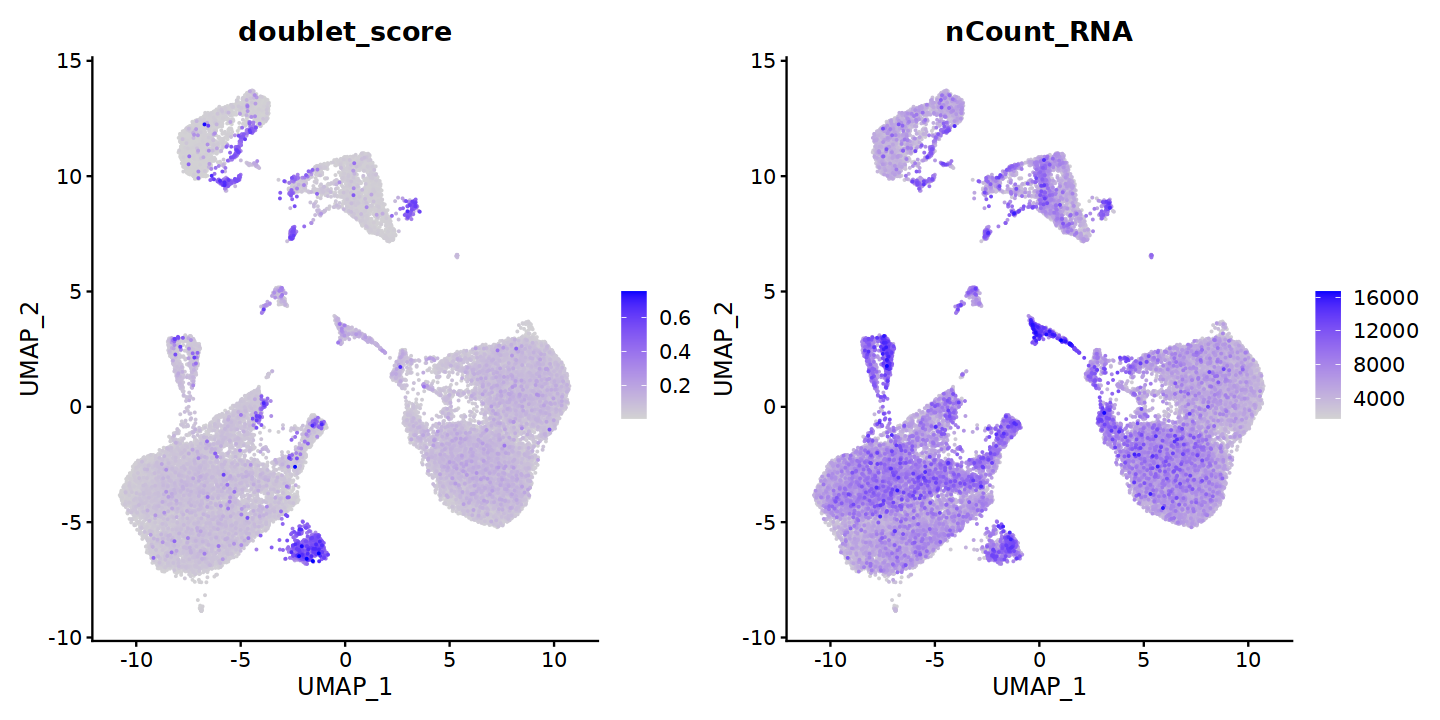

In [6]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("doublet_score", "nCount_RNA"), order = TRUE)

In [7]:
head(seurat_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample_org,timepoint,replicate,sample_id,pct_mt,percent.ribo,doublet_score,doublet_pred,S.Score,G2M.Score,Phase,old.ident
,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>,<fct>
T6_1_AAACCTGAGAATGTGT-1,SCGRES_105_106,3417,1730,OS0075_1,T6,1,T6_1,2.721686,12.730465,0.02323302,FALSE,-0.03026350,-0.047605549,G1,SCGRES_105_106
T6_1_AAACCTGAGAGGACGG-1,SCGRES_105_106,7725,2726,OS0075_1,T6,1,T6_1,2.627832,28.660194,0.06380824,FALSE,-0.02019055,0.037637890,G2M,SCGRES_105_106
T6_1_AAACCTGAGAGGTTAT-1,SCGRES_105_106,4382,2129,OS0075_1,T6,1,T6_1,1.688727,13.646737,0.04568528,FALSE,-0.02176373,-0.114262672,G1,SCGRES_105_106
T6_1_AAACCTGAGATAGCAT-1,SCGRES_105_106,12552,3452,OS0075_1,T6,1,T6_1,1.681007,5.799873,0.10079328,FALSE,0.50593224,0.070583537,S,SCGRES_105_106
T6_1_AAACCTGAGATGTGGC-1,SCGRES_105_106,2838,1566,OS0075_1,T6,1,T6_1,1.585624,11.733615,0.03327941,FALSE,-0.05312556,-0.002981258,G1,SCGRES_105_106
T6_1_AAACCTGAGCAGCCTC-1,SCGRES_105_106,4749,2146,OS0075_1,T6,1,T6_1,2.274163,15.161087,0.04284581,FALSE,-0.01896749,-0.023303527,G1,SCGRES_105_106


### First clustering to localize doublets

In [8]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:15)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30903
Number of edges: 1001839

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9711
Number of communities: 11
Elapsed time: 8 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30903
Number of edges: 1001839

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9536
Number of communities: 15
Elapsed time: 9 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30903
Number of edges: 1001839

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9412
Number of communities: 18
Elapsed time: 9 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30903
Number of edges: 1001839

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9306
Number of communities: 19
Elapsed time: 9 seconds
Modulari

In [9]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

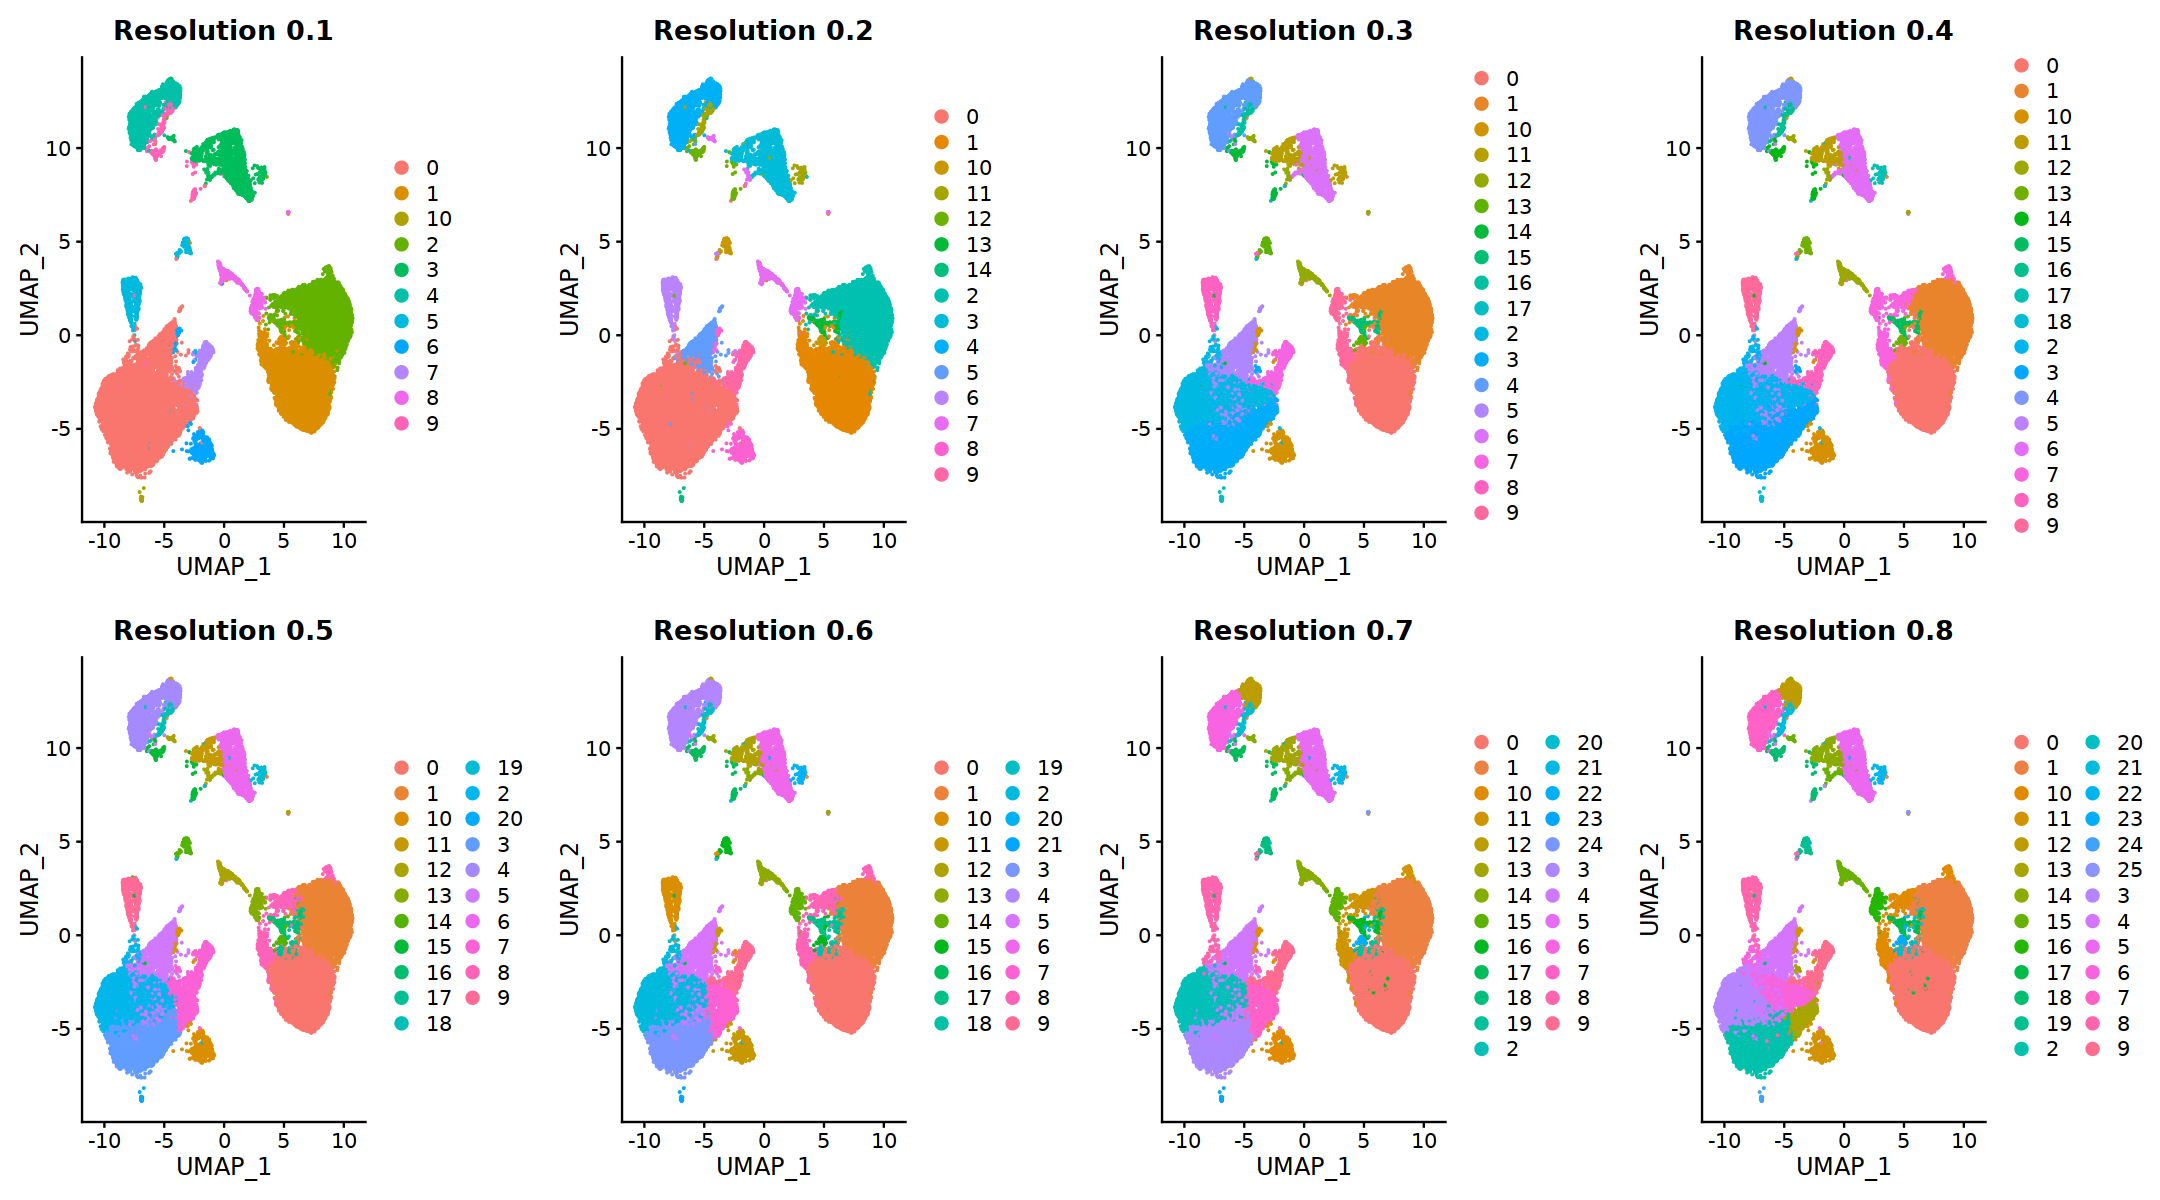

In [10]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [11]:
seurat_obj <- FindClusters(seurat_obj, resolution = 0.2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30903
Number of edges: 1001839

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9536
Number of communities: 15
Elapsed time: 9 seconds


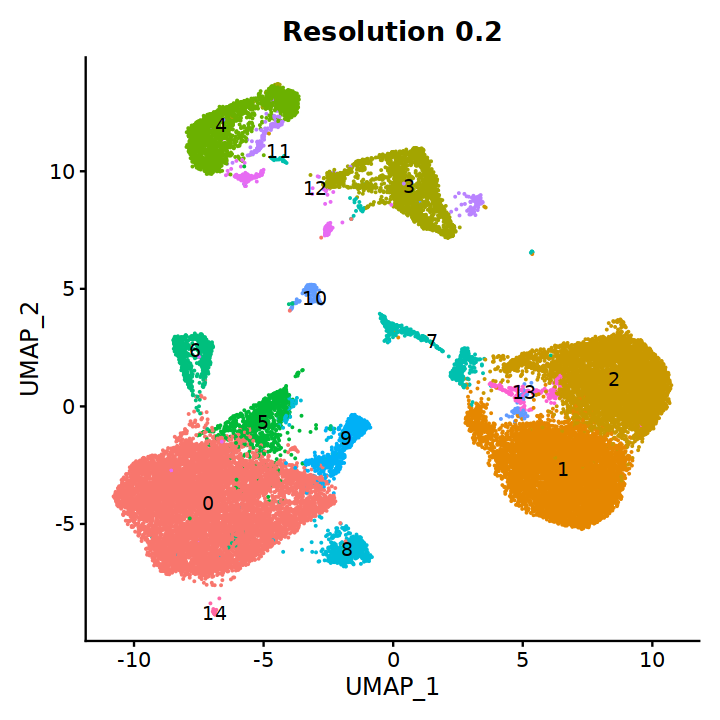

In [12]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T) + NoLegend() +
  labs(title="Resolution 0.2") + theme(plot.title = element_text(hjust = 0.5))

### Obtain markers to corroborate doublets by gene expression

In [13]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, only.pos=T,
                              logfc.threshold = 0.1, random.seed=0, 
                              max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [14]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-first_clustering_{timepoint}.csv")))

In [15]:
markers <- c("PTPRC","nCount_RNA", "nFeature_RNA",
             "doublet_score",
             "CD3E", "CD3D","NCAM1","KLRD1","FCGR3A",
             "CD14", "CD68", 
             "S100A8", "SPP1", "CD163", "MSR1",
             "IG")

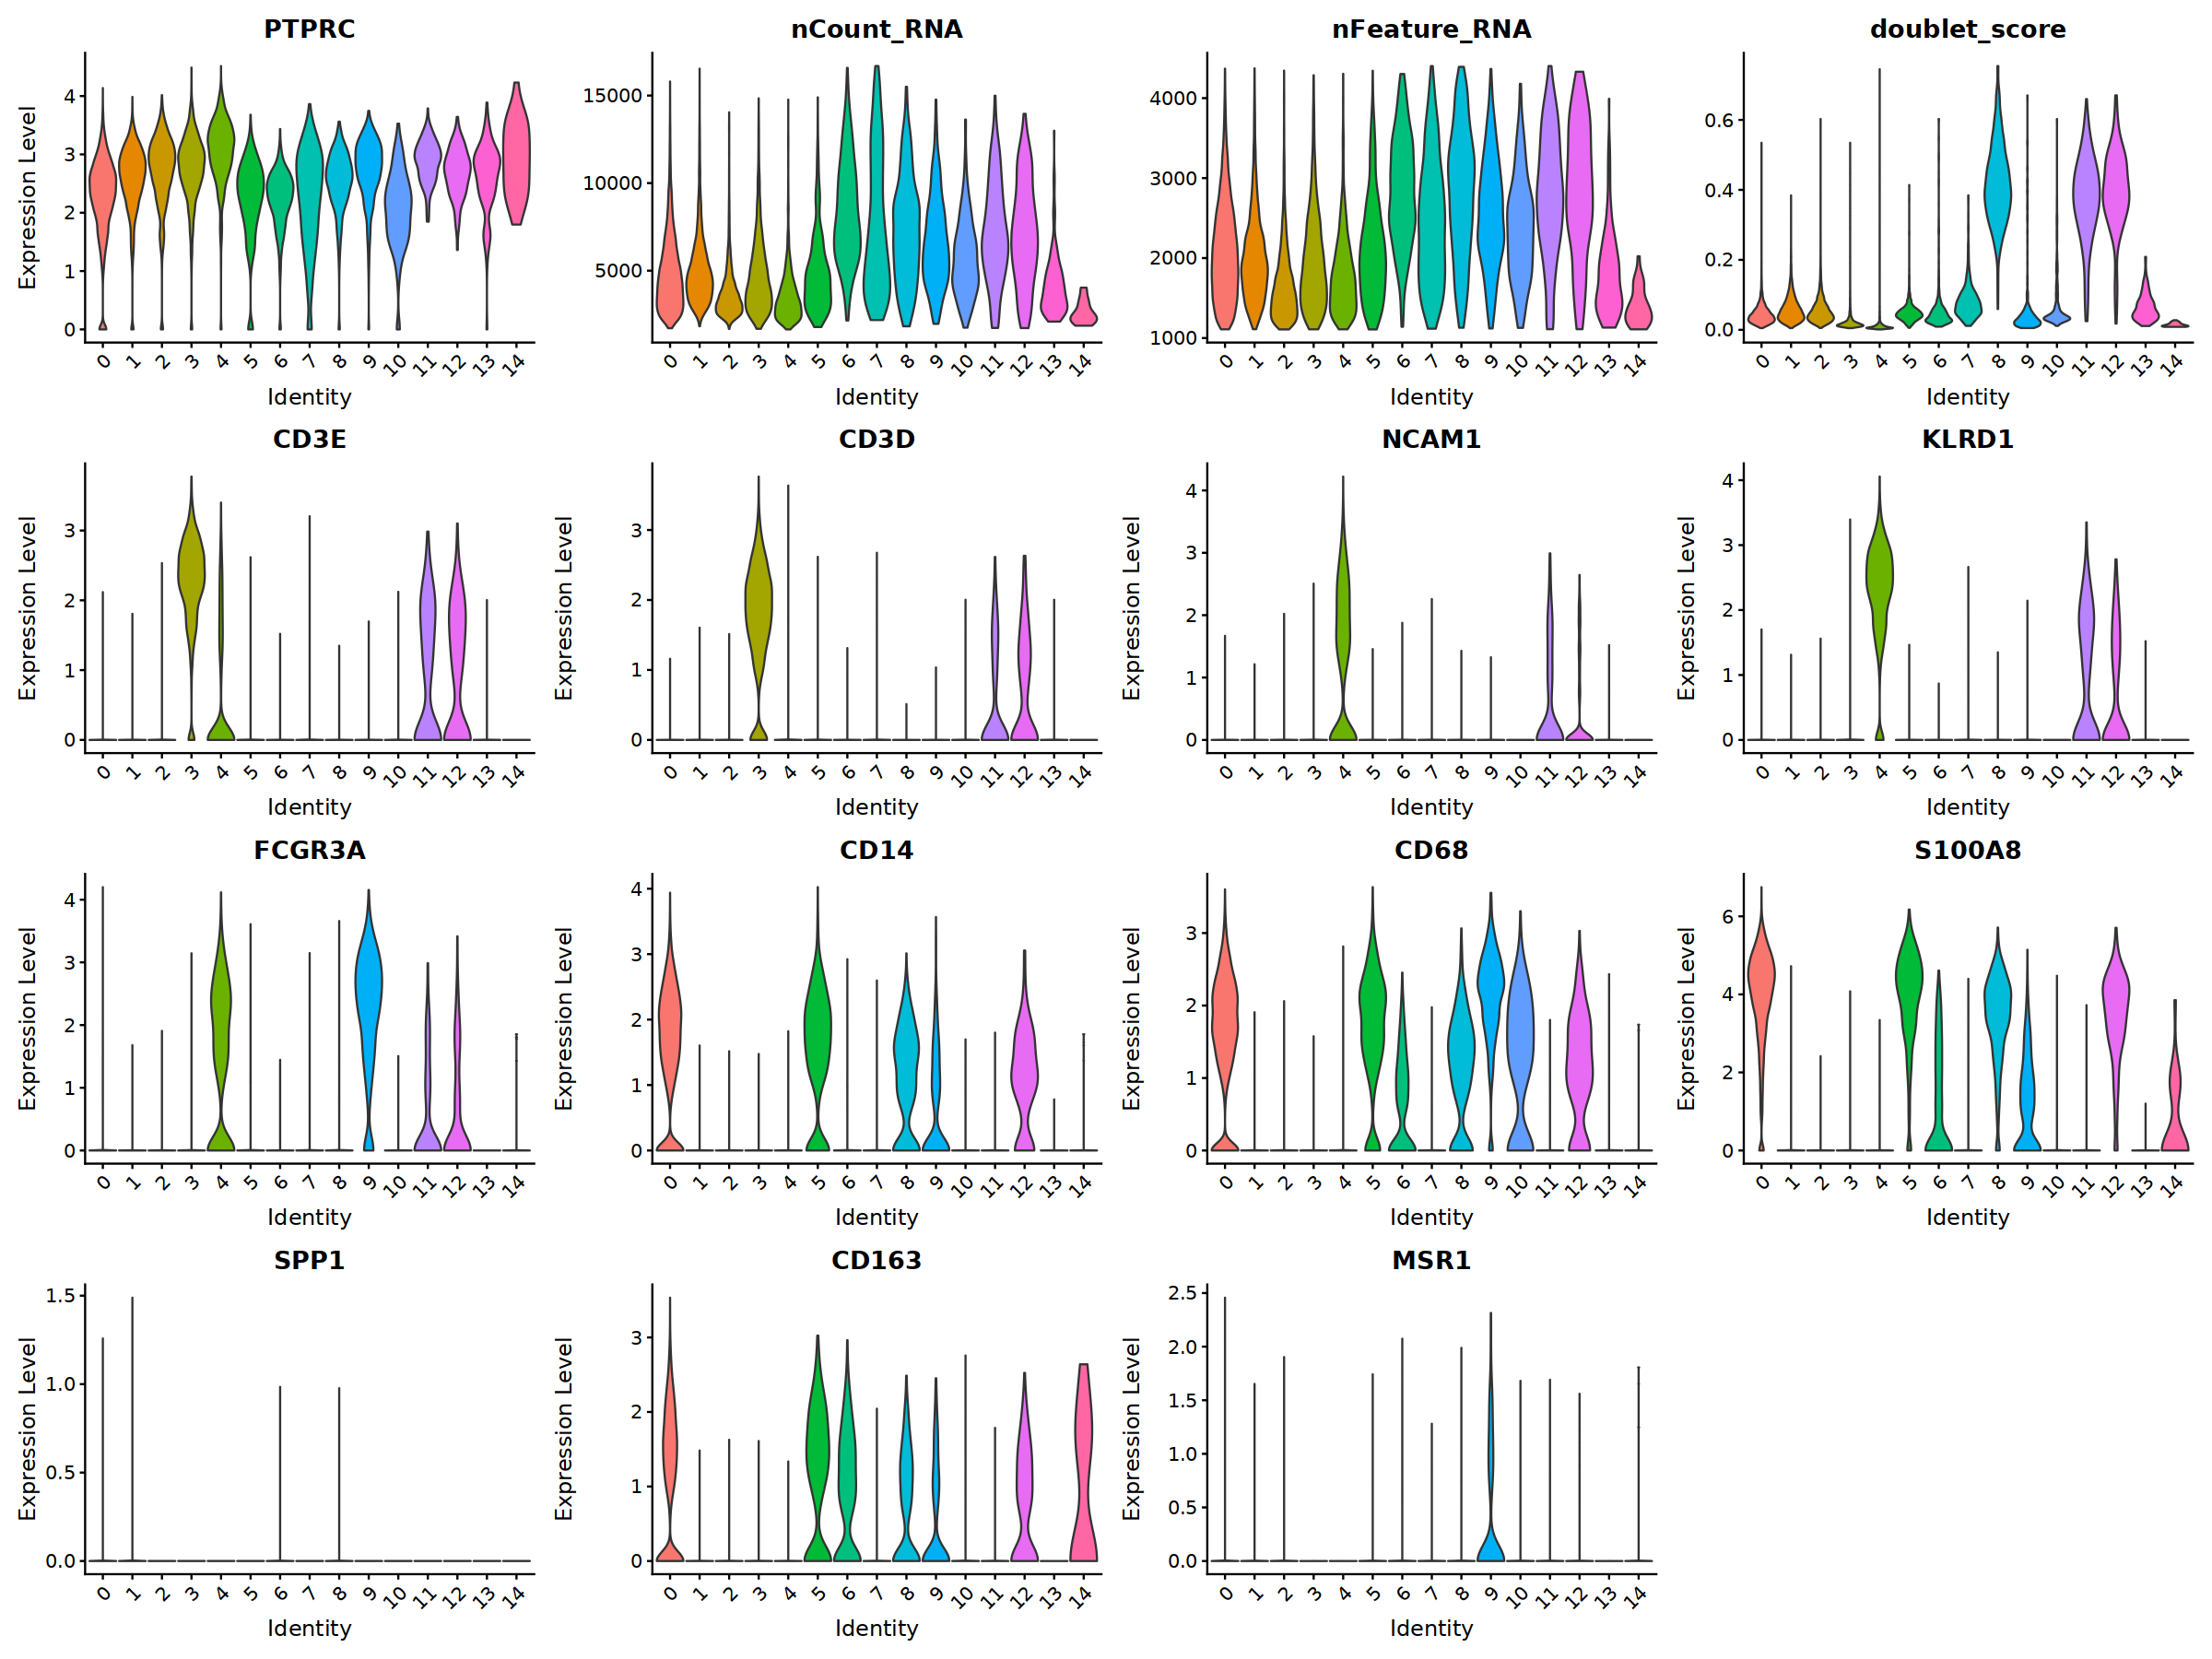

In [16]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4, pt.size = 0)

Doublets

In [17]:
c <- 8
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
S100A82,4.781751e-76,0.5802932,0.965,0.376,1.478996e-71,8,S100A8
LYZ3,2.642493e-48,0.4463994,0.999,0.407,8.173232e-44,8,LYZ
S100A92,1.475033e-68,0.4353941,0.993,0.403,4.562278e-64,8,S100A9
THBS12,2.420842e-38,0.4293091,0.576,0.239,7.487664e-34,8,THBS1
ARHGAP262,1.612432e-46,0.4103364,0.942,0.493,4.987251e-42,8,ARHGAP26
VCAN3,2.473463e-53,0.4091721,0.943,0.368,7.650420e-49,8,VCAN
IFI303,1.527858e-42,0.3840574,0.988,0.571,4.725664e-38,8,IFI30
S100A63,5.943806e-40,0.3826260,1.000,0.663,1.838419e-35,8,S100A6
FTL2,2.940999e-42,0.3787699,1.000,0.979,9.096511e-38,8,FTL


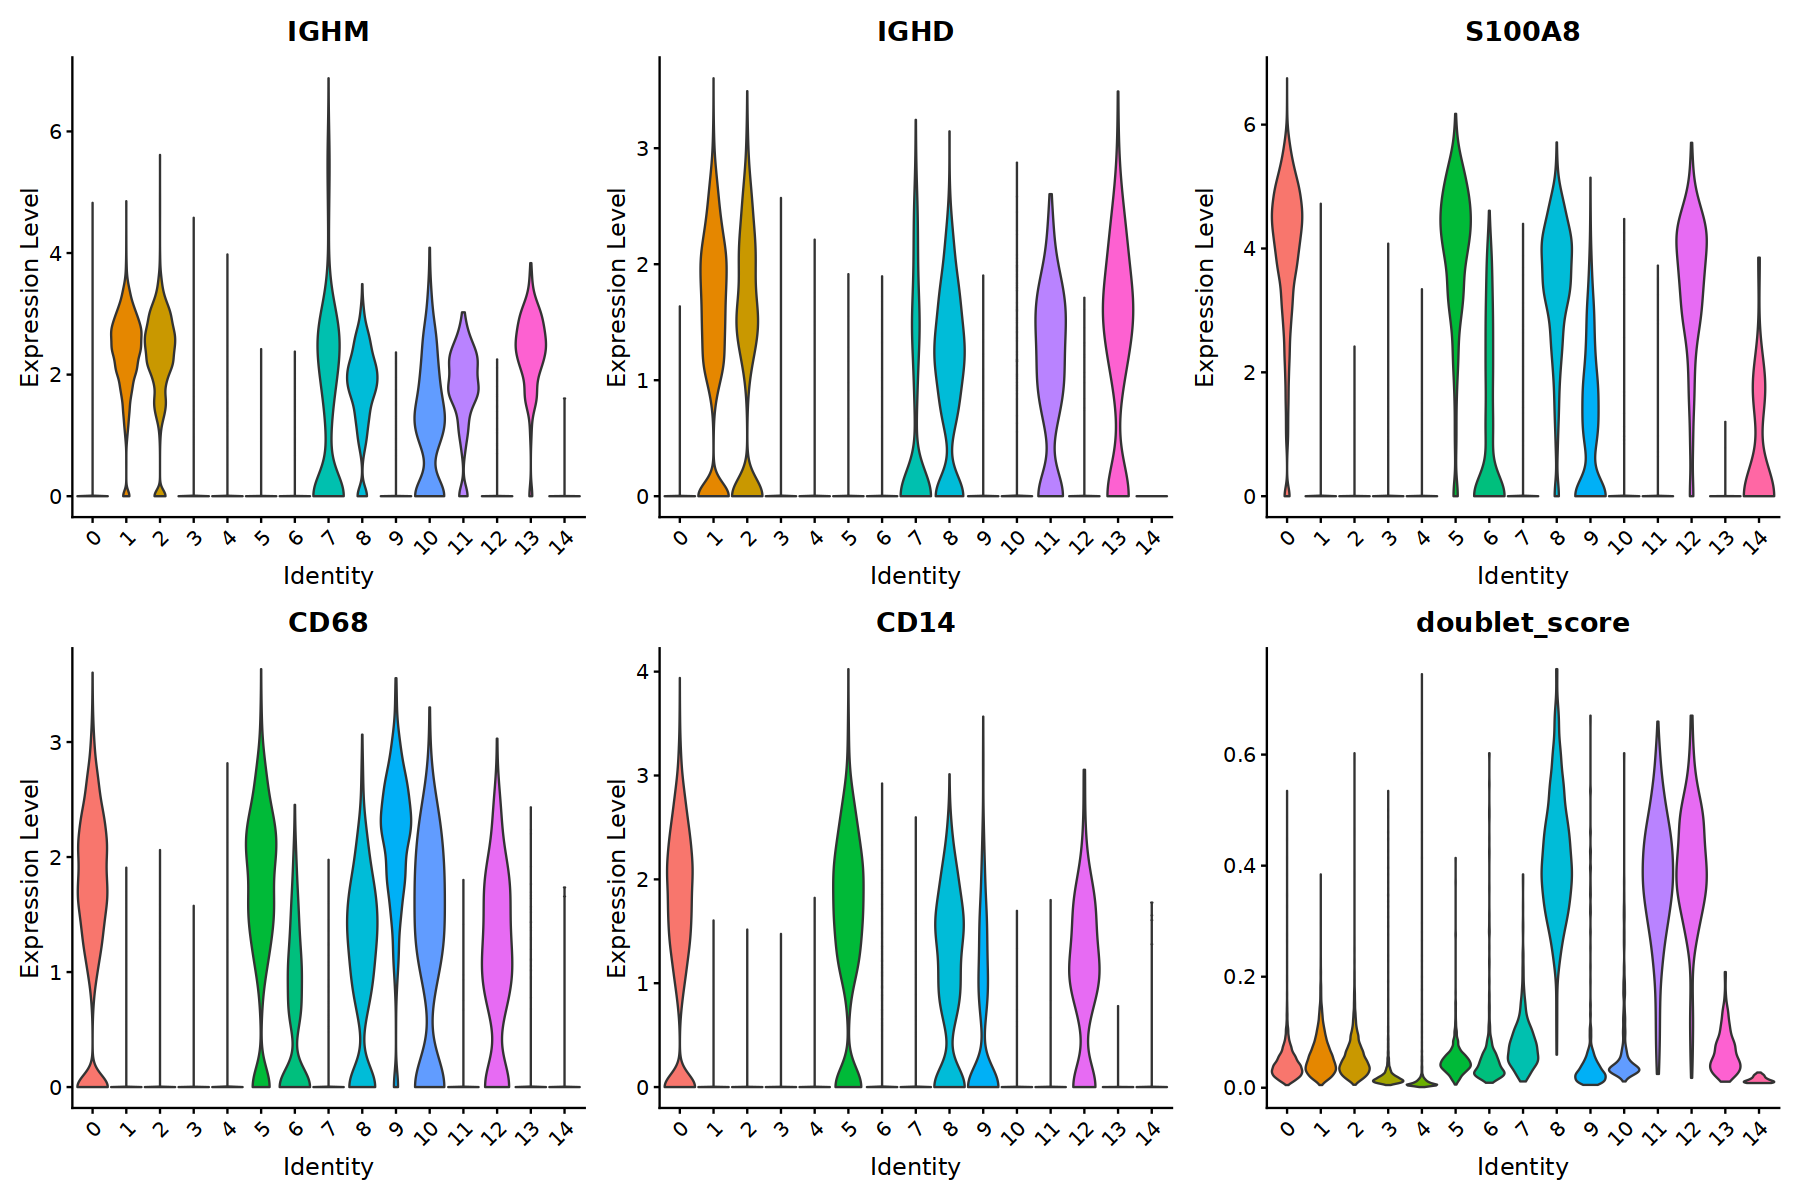

In [18]:
options(repr.plot.width = 15, repr.plot.height = 10, warn=-1,verbose = FALSE)
more_markers = c("IGHM", "IGHD", "S100A8", "CD68", "CD14", "doublet_score")
VlnPlot(seurat_obj,
            feature=more_markers, 
            ncol=3, pt.size = 0)

In [19]:
c <- 11
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
GNLY1,3.867694e-71,1.6267050,0.578,0.090,1.196278e-66,11,GNLY
NKG71,2.147605e-53,1.4142932,0.578,0.130,6.642543e-49,11,NKG7
IL322,4.354412e-101,1.3120992,0.815,0.133,1.346820e-96,11,IL32
CTSW1,1.612933e-67,1.3117519,0.596,0.107,4.988801e-63,11,CTSW
IL2RB1,1.526592e-79,1.2684762,0.613,0.092,4.721750e-75,11,IL2RB
PRF11,1.418276e-71,1.2481051,0.589,0.094,4.386726e-67,11,PRF1
CD73,3.965470e-99,1.2262509,0.777,0.136,1.226520e-94,11,CD7
CD2472,2.214476e-105,1.2157912,0.819,0.134,6.849376e-101,11,CD247
IFITM12,1.057242e-72,1.1736191,0.986,0.539,3.270049e-68,11,IFITM1


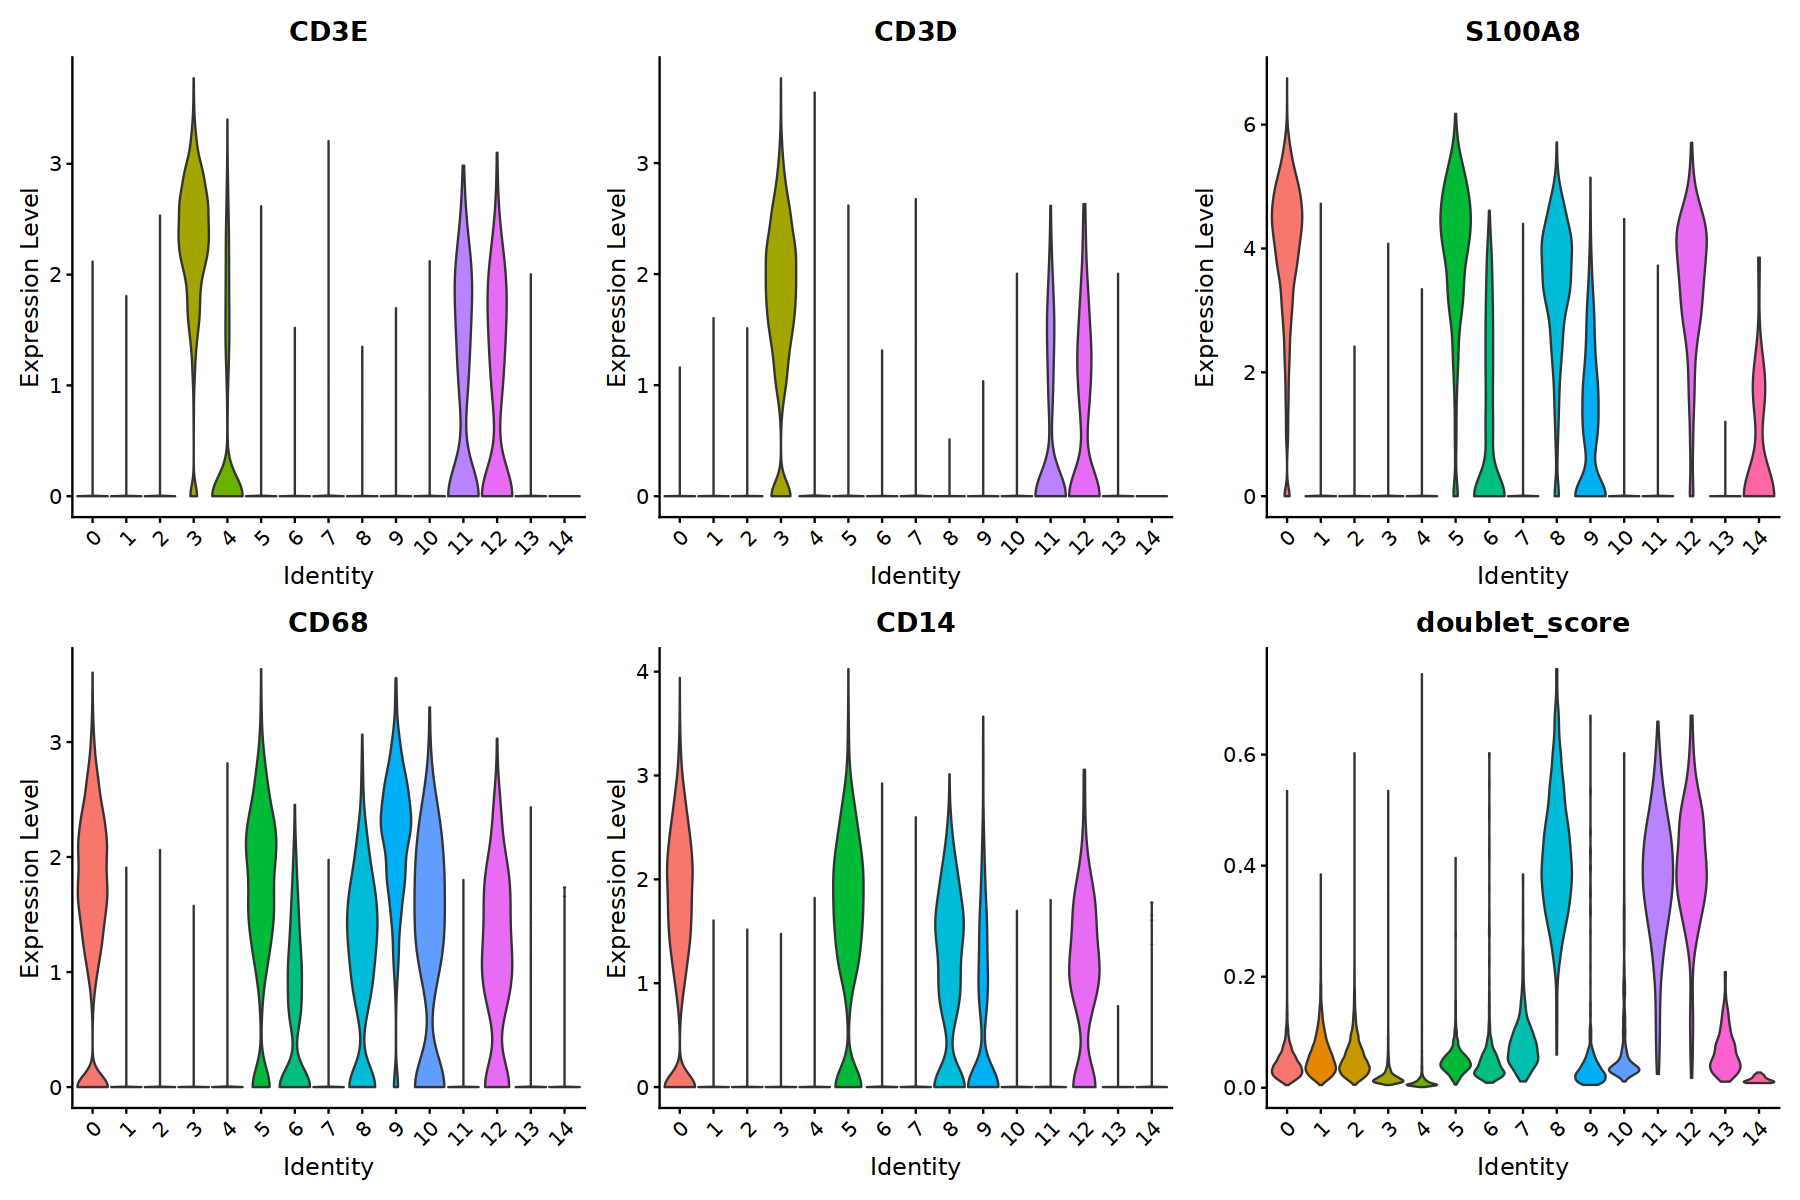

In [20]:
options(repr.plot.width = 15, repr.plot.height = 10, warn=-1,verbose = FALSE)
more_markers = c("CD3E", "CD3D", "S100A8", "CD68", "CD14", "doublet_score")
VlnPlot(seurat_obj,
            feature=more_markers, 
            ncol=3, pt.size = 0)

In [21]:
c <- 12
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
IL323,3.311119e-74,1.3675904,0.748,0.134,1.024129e-69,12,IL32
NKG72,8.367046e-50,1.2082398,0.594,0.130,2.587927e-45,12,NKG7
GNLY2,4.685642e-48,1.1713723,0.508,0.091,1.449269e-43,12,GNLY
CCL54,2.564830e-38,1.0835499,0.512,0.126,7.933020e-34,12,CCL5
IFITM13,1.170839e-58,1.0809781,0.980,0.540,3.621405e-54,12,IFITM1
CD2473,3.039146e-75,1.0594581,0.764,0.135,9.400078e-71,12,CD247
PRKCH3,4.159855e-68,1.0304513,0.823,0.203,1.286643e-63,12,PRKCH
CTSW2,2.784265e-51,0.9781091,0.571,0.108,8.611731e-47,12,CTSW
CD3E3,4.597241e-54,0.9700683,0.583,0.102,1.421927e-49,12,CD3E


In [22]:
c <- 7
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
IGHA1,2.615774e-90,5.529684,0.399,0.028,8.090590e-86,7,IGHA1
JCHAIN,3.405079e-97,4.522966,0.661,0.209,1.053191e-92,7,JCHAIN
IGHG1,5.464650e-40,4.234203,0.205,0.012,1.690216e-35,7,IGHG1
IGKV4-11,4.216677e-18,3.992962,0.179,0.049,1.304218e-13,7,IGKV4-1
IGKC2,3.491166e-54,3.960661,0.556,0.229,1.079818e-49,7,IGKC
IGHV3-7,4.066601e-11,3.900441,0.111,0.035,1.257800e-06,7,IGHV3-7
IGHA2,1.280757e-50,3.807815,0.211,0.009,3.961382e-46,7,IGHA2
IGHV3-232,5.008787e-09,3.557817,0.149,0.073,1.549218e-04,7,IGHV3-23
IGHV3-30,5.696637e-07,3.308124,0.107,0.041,1.761970e-02,7,IGHV3-30


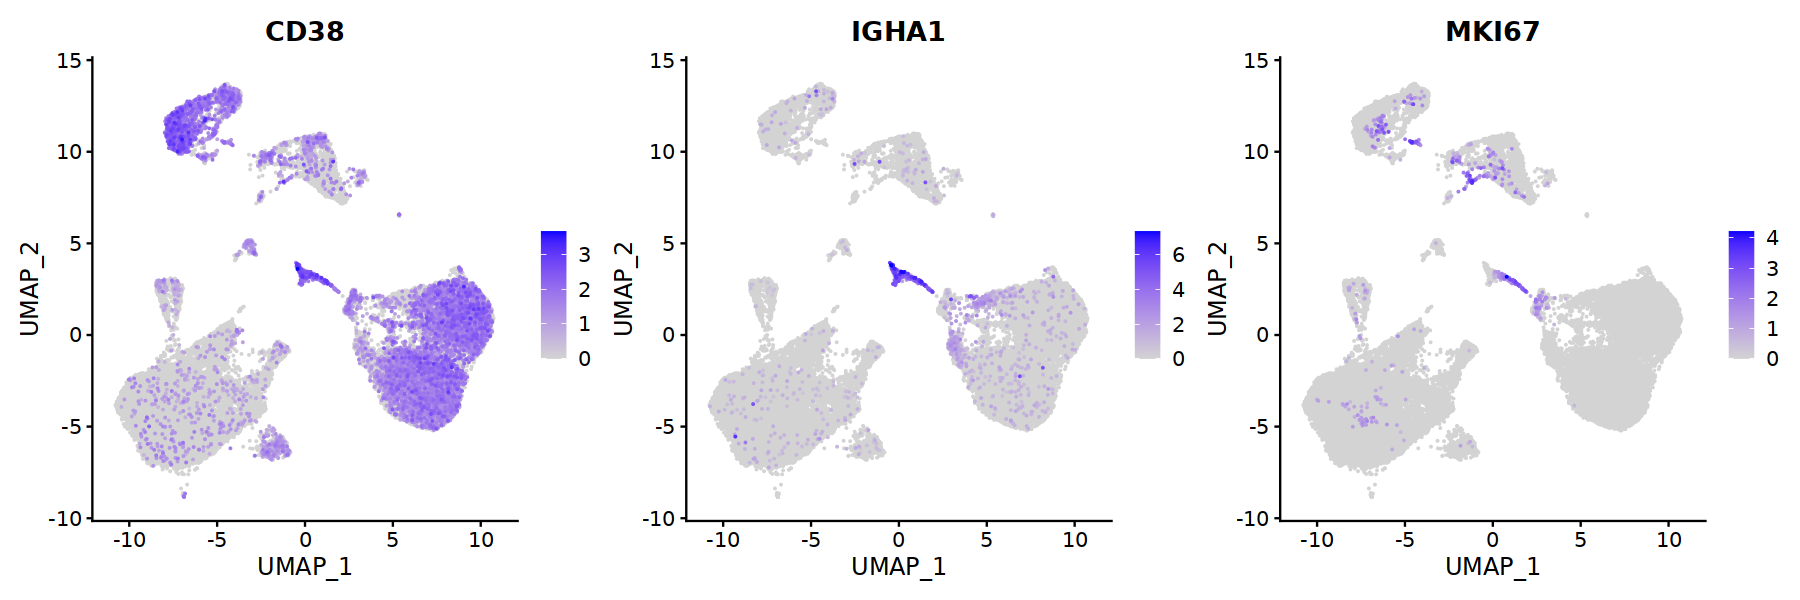

In [23]:
options(repr.plot.width = 15, repr.plot.height = 5, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, ncol=3, order=T,
            feature=c("CD38", "IGHA1", "MKI67"))

### Remove cells

Doublets, low quality etc 

In [24]:
seurat_obj <- subset(seurat_obj, idents=c(8,11,12), invert=TRUE)

In [25]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
30469   461 


An object of class Seurat 
30469 features across 29674 samples within 1 assay 
Active assay: RNA (30469 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap

## Re-do embedding and clustering

In [26]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [27]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 30469 29674 
metadata(0):
assays(2): counts logcounts
rownames(30469): OR4F5 AL627309.1 ... AC136616.2 AC023491.2
rowData names(0):
colnames(29674): T6_1_AAACCTGAGAATGTGT-1 T6_1_AAACCTGAGAGGACGG-1 ...
  T6_2_TTTGTCATCTGCTGCT-1 T6_2_TTTGTCATCTGTCCGT-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(2): PCA UMAP
mainExpName: RNA
altExpNames(0):

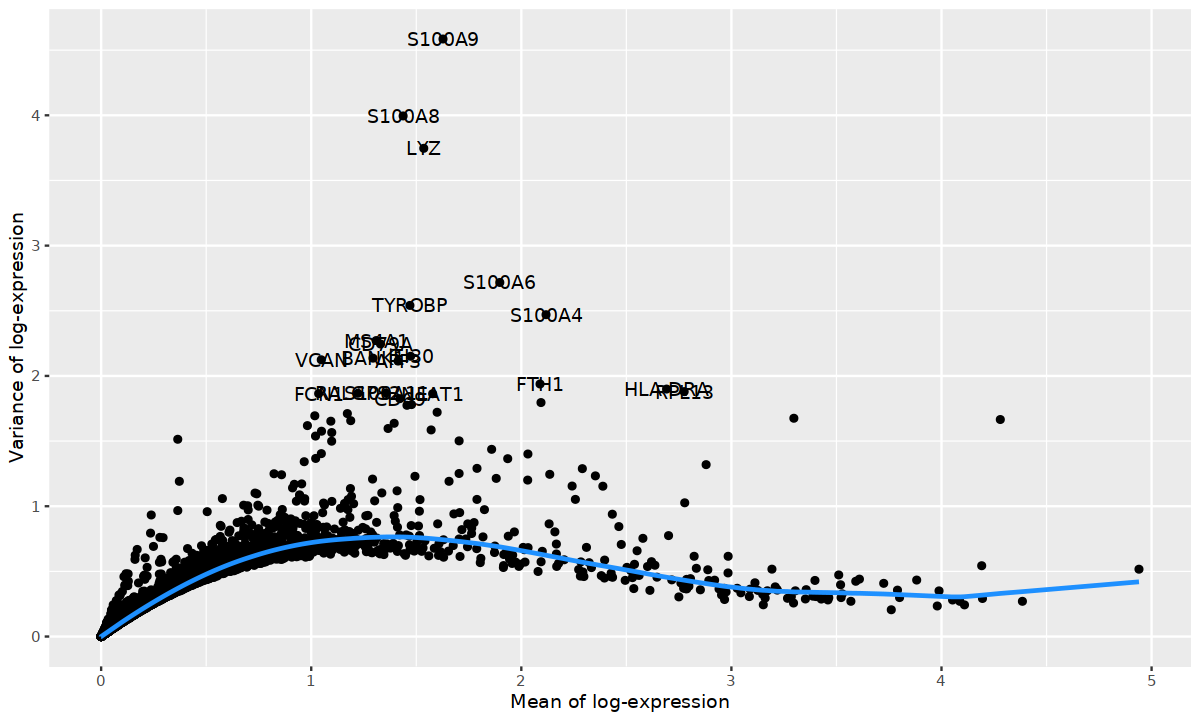

In [28]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [29]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 407

In [30]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

# remove BCR genes
hvgs <- hvgs[!grepl("^IG[HKL]V", hvgs)]
hvgs <- hvgs[!grepl("^IG[HKL]J", hvgs)]
hvgs <- hvgs[!grepl("^IG[KL]C", hvgs)]
hvgs <- hvgs[!grepl("^IGH[ADEGM]", hvgs)]
length(hvgs)

[1] 194

In [31]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  CD79A, MS4A1, AFF3, CD69, BANK1, RALGPS2, FCRL1, BACH2, TCL1A, CD79B 
	   EBF1, NIBAN3, RPSA, CD52, HLA-DQA1, CD37, RPLP0, MT-ND6, TXNIP, CD74 
	   HLA-DPB1, JCHAIN, HLA-DPA1, SKAP1, HLA-DRA, SOX5, HLA-DQB1, IFITM1, TCL1B, AL589693.1 
Negative:  TYROBP, LYZ, S100A9, S100A11, FCN1, S100A6, AIF1, S100A8, VCAN, PLXDC2 
	   FCER1G, LGALS1, S100A4, MNDA, ANXA1, ARHGAP26, SERPINA1, IFI30, NEAT1, S100A10 
	   SRGN, LST1, NAMPT, FTL, CST3, TSPO, SLC8A1, PSAP, MS4A6A, SAT1 
PC_ 2 
Positive:  NKG7, PRF1, CTSW, GNLY, CST7, CD7, CD247, KLRD1, GZMA, IL2RB 
	   GZMB, CCL5, PRKCH, KLRF1, HOPX, ADGRG1, IL32, GZMH, KLRB1, FGFBP2 
	   SPON2, NCAM1, IFITM1, KLRC1, SKAP1, KLRC2, XCL2, DTHD1, XCL1, CCL4 
Negative:  HLA-DRA, HLA-DRB1, CD74, HLA-DQB1, HLA-DPB1, HLA-DPA1, HLA-DQA1, CD37, MS4A1, BANK1 
	   CD79A, RALGPS2, FCRL1, AFF3, TCL1A, EBF1, CD79B, IFI30, NIBAN3, CTSS 
	   FTL, LST1, LYZ, RPLP0, FCN1, MS4A6A, AIF1, S100A9, SAT1, PLXDC2 
PC_ 3 
Positive

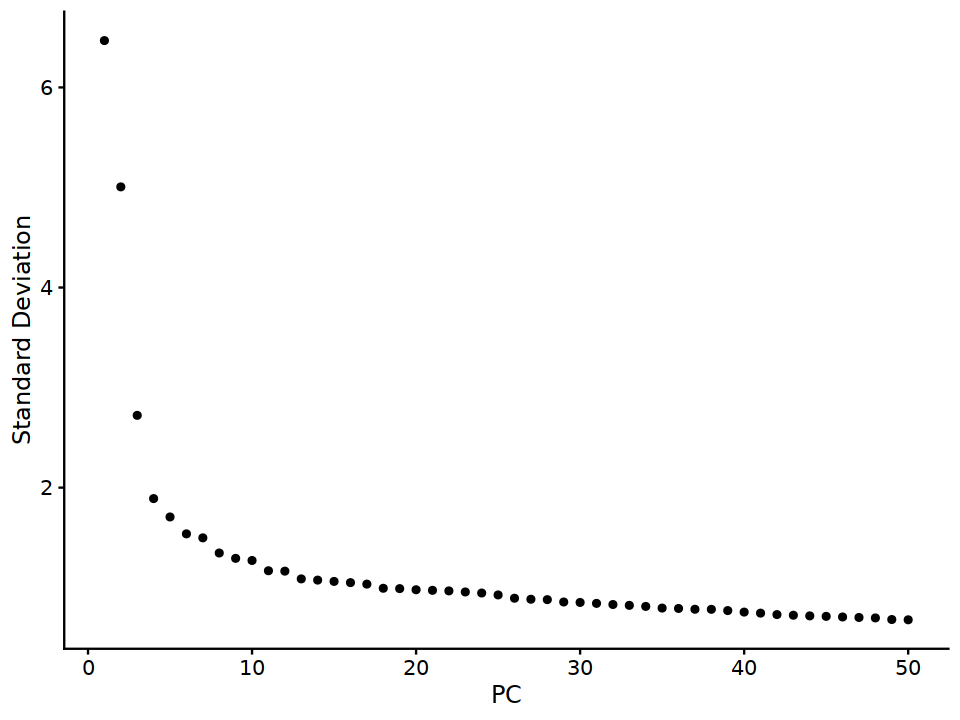

In [32]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [33]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:15,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

10:09:13 UMAP embedding parameters a = 0.9922 b = 1.112

10:09:13 Read 29674 rows and found 15 numeric columns

10:09:13 Using Annoy for neighbor search, n_neighbors = 30

10:09:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:09:16 Writing NN index file to temp file /scratch_tmp/33943067/RtmpUcY1Hj/file3efc7b0f199c

10:09:16 Searching Annoy index using 1 thread, search_k = 3000

10:09:27 Annoy recall = 100%

10:09:28 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:09:30 Initializing from normalized Laplacian + noise (using irlba)

10:09:32 Commencing optimization for 200 epochs, with 1242922 positive edges

10:10:04 Optimization finished



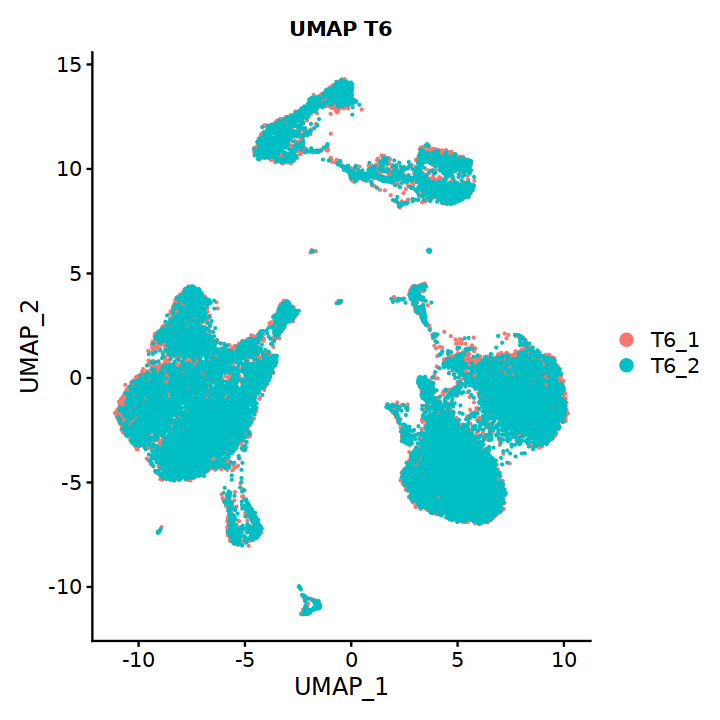

In [34]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

### Clustering 

In [35]:
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:15)

Computing nearest neighbor graph

Computing SNN



In [36]:
reso = 0.2

In [37]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29674
Number of edges: 962622

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9529
Number of communities: 13
Elapsed time: 7 seconds


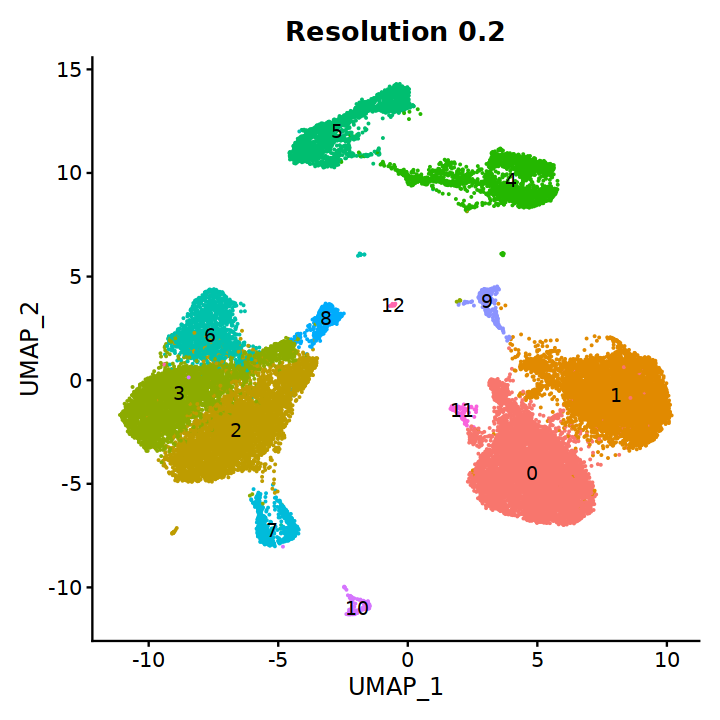

In [38]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Compute markers

In [39]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct=0.1, 
                              logfc.threshold=0.1, only.pos=T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



# Save

In [40]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.rds")))

In [41]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.csv")))

# Session Info

In [42]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_